# Model Code for: DIN Loading Module
##  Island Wide Nutrient Modeling and Quantification of Coastal Freshwater Discharge for Tutuila, American Samoa, Script 2 of 2

The DIN Loading Module script contains the computational steps used to develop a Tutuila-wide DIN loading model as documented in the report "Island Wide Nutrient Modeling and Quantification of Coastal Freshwater Discharge for Tutuila, American Samoa" as authored by Shuler Hydrologic LLC and delivered to the American Samoa Environmental Protection Agency. The purpose of posting this project online in an open-source setting is to increase its methodological transparency and make the study entirely reproducible or modifiable as the user’s discretion. 

# Disclaimer
This script is provided as open-source software on the condition that neither Shuler Hydrologic LLC nor the American Samoa EPA shall be held liable for any damages resulting from the authorized or unauthorized use of the information. No warranty, expressed or implied, is made by Shuler Hydrologic LLC or the American Samoa EPA as to the accuracy and functioning of the program and related program material nor shall the fact of distribution constitute any such warranty and no responsibility is assumed by Shuler Hydrologic LLC in connection therewith.

This information is preliminary or provisional and is subject to revision.  This software is provided "AS IS."

Note that sensitive information, or datasets that are not publically available, are not posted in raw forms. The model code is licensed under the GNU General Public License v3.0 which is an open-access license designed to explicitly affirm any user’s unlimited permission to run, copy, and use the unmodified code from this repository. Please note that some raw datasets used in this work are not owned by the authors and may be subject to other licenses or conditions.

#### Prepared by:  
      Shuler Hydrologic LLC, Honolulu, HI 96826      
      
#### Prepared for:  
    American Samoa Environmental Protection Agency, P.O. Box PPA, Pago Pago, AS 96799

# Implementation

### 1) Import modules and set relative paths

In [2]:
import numpy as np
import os
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import statsmodels.api as sm
import scipy.optimize as opt

homedir = os.getcwd()

Output = os.path.join('..', "Output")
if not os.path.exists(Output):
    os.makedirs(Output)
                      
fig_path = os.path.join(Output, "Figures")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

### 2) Define loacal functions used in this script for error calculation

In [3]:
# multiplication error 
def mul_err(x, y, xE, yE):         # x and y are the things being multiplied xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = (x*y)*np.sqrt(  (xE/x)**2+(yE/y)**2  )
    return SE

# Division error 
def div_err(x, y, xE, yE):         # x and y are the things being divided xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = (x/y)*np.sqrt(  (xE/x)**2+(yE/y)**2  )
    return SE

# addition error 
def add_err(xE, yE):         # x and y are the things being added xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = np.sqrt( xE**2+yE**2 )
    return SE

# subtraction error 
def sub_err(xE, yE):         # x and y are the things being subtracted xE is the error on x and yE is error on y. can be single number of a column/array  
    SE = np.sqrt( xE**2+yE**2 )
    return SE


def add_err3(xE, yE, zE): 
    SE = np.sqrt( xE**2 + yE**2 + zE**2 )
    return SE

### 3) Load and muggle stream sample water quality data
This cell will: 
- Load raw data from the base raw data file "Consolidated_All_data_MASTER.xlsx"
- Determine which samples were take during runoff conditions vs during baseflow conditions based on the stream stage data
- summarize each sample site into a single row datadrame with average values for all samples, and can split up by RO or BF stage

In [4]:
# load up the excel data sheet
datapath = os.path.join("..", 'Raw_data', 'Tabular', "Consolidated_All_data_MASTER.xlsx")
data_xls = pd.read_excel(datapath, sheet_name='Consolidated_stream_data')#  index_col=0)  # read  xlsx to memory
data_xls = data_xls.dropna(subset=['Lat'])

# this block calculates the threshold value to define runoff vs baseflow conditions based on a multiplier of the mean recorded gauge height, change value below to mess with the threshold
ave_height_multiplyer_value = 1    # Currently 1.11 is the value that produces an average BF days to total flow days of 70% which is between Q60 and Q80 cite batsoni and Oki. (Actually using just mean for simplicity

av_hts = []; Vst = []
for i in data_xls['Village_stream'].unique():
    station_to_review = i
    review_frame = data_xls[data_xls['Village_stream'] == station_to_review]
    ave_ht =  review_frame['Guage_height_in'].mean()*ave_height_multiplyer_value   # hmm this uses the mean value to threshold RO from BF stream heights
    #ave_ht = np.percentile(review_frame['Guage_height_in'], 32)                    # and this uses a percentile value. I think using mean value straight for now. 
    av_hts.append(ave_ht); Vst.append(i)   
heighte_frame = pd.DataFrame({'Village_stream':Vst, 'Ave_gauge_height':av_hts})   # this is a dataframe of the stream names and the unique threshold heights 

def calculate_flo_type(row):                # this is a function to calculate BF or RO for each sample, based on the streams individual threshold height
    extracto = row['Village_stream']
    needval = heighte_frame[heighte_frame['Village_stream'] == extracto]
    ave_height_val = needval['Ave_gauge_height'].values[0]
    
    if row['Guage_height_in'] > ave_height_val:
        row['Flow_type'] = "RO"
    else:
        row['Flow_type'] = "BF"
        
    return row['Flow_type']

data_xls['Flow_type'] = data_xls.apply(calculate_flo_type, axis=1)


# this block creates a summary dataframe of each site
nam = []; count = []; avedin = []; avedin_ERR = []; aveSAL = []; avedin_BF =[]; avedin_BF_ERR =[]; avedin_RO =[]; avedin_RO_ERR =[]; cntBF = []; cntRO = []

for i in data_xls['Village_stream'].unique():
    tframe = data_xls[data_xls['Village_stream']==i]
    
    nam.append(i)
    count.append(len(tframe))
    avedin.append((tframe['DIN_uM']/71.39).mean())   # /71.39 is to convert uM of N to mg/L of N
    avedin_ERR.append((tframe['DIN_uM']/71.39).std())
    aveSAL.append(tframe['Salinity'].mean())
    

    cntBF.append(len(tframe[tframe['Flow_type'] == "BF"]))
    cntRO.append(len(tframe[tframe['Flow_type'] == "RO"]))
    
    avedin_BF.append((tframe[tframe['Flow_type'] == "BF"]['DIN_uM']/71.39).mean())
    avedin_BF_ERR.append((tframe[tframe['Flow_type'] == "BF"]['DIN_uM']/71.39).std())
    avedin_RO.append((tframe[tframe['Flow_type'] == "RO"]['DIN_uM']/71.39).mean())
    avedin_RO_ERR.append((tframe[tframe['Flow_type'] == "RO"]['DIN_uM']/71.39).std())
    
Stream_sample_summary_frame = pd.DataFrame({"Village_st":nam, "Samp_count":count, "Ave_DIN_uM":avedin, "Ave_DIN_uM_ERR":avedin_ERR, "Ave_Sal":aveSAL,
                              "aveDIN_BF":avedin_BF,"aveDIN_BF_ERR":avedin_BF_ERR, "aveDIN_RO":avedin_RO, "aveDIN_RO_ERR":avedin_RO_ERR, "BFcnt":cntBF, "ROcnt":cntRO})

Stream_sample_summary_frame['BF_TF_ratio'] = Stream_sample_summary_frame['BFcnt']/Stream_sample_summary_frame['Samp_count']
#Stream_sample_summary_frame.to_csv("Stream_sample_summary_frame.csv")

### 4) Load and muggle Coastal Spring water quality data

Note that coastal spring samples were unmixed to fresh end member saminities with the oceanic end member used in Shuler et al. 2017 and the method from Hunt and Rosa (2009):

Ocean unmixed DIN concentrations were caluculated using the following unmixing calculation taken from Hunt and Rosa (2009): 

Sample_DIN + (Samp_DIN-Ocean_DIN)*(Sample_Salinity-Fresh_salinity)/(Ocean_Salinity -Sample_Salinity)

     Where
     Ocean_Salinity = 35.27
     Fresh Salinity = 0.1
     Ocean_DIN = 0.370 uM
     
(this calculation was performed previously in an excel sheet)

In [5]:
# load up the excel data sheet
data_xls2 = pd.read_excel(datapath, sheet_name='Consolidated_CSP_data')#  index_col=0)  # read  xlsx to memory
data_xls2 = data_xls2.dropna(subset=['Lat'])       # remove any rows with no lat meaning no data

# this block creates a summary dataframe of each site
nam = []; count = []; avedin = []; std = []; aveSAL = [];

for i in data_xls2['Uniqe_ID'].unique():
    tframe = data_xls2[data_xls2['Uniqe_ID']==i]
    
    nam.append(i)
    count.append(len(tframe))
    avedin.append((tframe['UNMIXED_DIN_uM']/71.39).mean())  # /71.39 is to convert uM of N to mg/L of N
    std.append((tframe['UNMIXED_DIN_uM']/71.39).std())
    aveSAL.append(tframe['Salinity'].mean())
    
CSP_sample_summary_frame = pd.DataFrame({"Uniqe_ID":nam, "Samp_count":count, "Ave_UnMix_CSP_DIN_mgpL":avedin, "Ave_UnMix_CSP_DIN_mgpL_ERR":std, "Ave_Sal":aveSAL})
#CSP_sample_summary_frame.to_csv("CSPs.csv")

### 5) Merge all data into giant dataframe
keyed out mainly by the Village_st code, 
but also my the Uniqe_ID code from the water budget model zones
includes stream sample data, land use sources (OSDS, Pigs_AG), and SWB2 components from the SWB2_model_R2R_ver2 script

In [6]:
# open up the land use factors shapefile and merge it on to the stream sample dataframe
gdf = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "AG_OSDS_PIGS_NATURAL_ACTIVE_WS.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
LUsource_frame = Stream_sample_summary_frame.merge(gdf, on='Village_st', how='right')
del LUsource_frame['geometry']

# open up the pumprates shapefile and merge it on to the land use dataframe
prates = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "Pumprates.shp"))
del prates['geometry']
LUsource_pump_frame = LUsource_frame.merge(prates, on='Uniqe_ID', how='outer')

# add on the SWB2 WB results for each watershed (note: using inner to omit the sheds that were not sampled.)
wb_results = pd.read_csv(os.path.join('..', "Workspace",'SWB2_results', 'WB_by_shed_m3pd_Fixed.csv'), index_col=0)     # this file comes out of the SWB2_model_R2R_ver2 script
merge_frame2 = LUsource_pump_frame.merge(wb_results, on='Uniqe_ID', how='outer')

# add shoreline lengths in km
perims = geopandas.read_file(os.path.join("..", "Raw_data", "GIS",  "Sub_basin_perimeters.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
del perims['geometry']
merge_frame2p5 = merge_frame2.merge(perims, on='Uniqe_ID', how='outer')

# add on the coastal springs where available
CSP_to_merge = CSP_sample_summary_frame[['Uniqe_ID','Ave_UnMix_CSP_DIN_mgpL','Ave_UnMix_CSP_DIN_mgpL_ERR']]
merge_frame3 = merge_frame2p5.merge(CSP_to_merge, on='Uniqe_ID', how='outer')

# Remove the baseflow from Leone Volcanic areas and add it in as SGD since these areas have no baseflow
merge_frame3 = merge_frame3.reset_index(drop = True)

no_Bflow_bros = ['WS_64_Tafuna Plain', 'WS_65_Fagatele - Larsen', 'WS_98_Leone_Maloata']  # list of zones with no known baseflow

for i in no_Bflow_bros:   # for each of those areas...
    for q in range(0, len(merge_frame3.index)):    # check each row
        
        if merge_frame3.at[q, 'Uniqe_ID'] == i:
            print(i)
            flow_to_add = merge_frame3.at[q, 'baseflow']                                        # grab the BF
            merge_frame3.at[q, 'SGD_m3pd'] = (merge_frame3.at[q, 'SGD_m3pd'] + flow_to_add)     # add it to the SGD
            merge_frame3.at[q, 'baseflow'] = 0                                                  # remove the BF
            
            
# make an SGD column that takes account of pumping
merge_frame3['SGD_m3pd_w_pumping']  = merge_frame3['SGD_m3pd'] - merge_frame3['TotGWQm3pd'] 

WS_64_Tafuna Plain
WS_65_Fagatele - Larsen
WS_98_Leone_Maloata


### 6) create loading colums based on some assumptions:  
 - 1: BF load is composed of aveDIN_BF and baseflow
 - 2: RO load is composed of aveDIN_RO and runoff
 - 3: SGD load is composed of Ave_UnMix_CSP_DIN_uM and SGD

In [7]:
merge_frame3['BF_DIN_lOAD_kgNpd'] = (merge_frame3['aveDIN_BF']/1000) * merge_frame3['baseflow']    # converting from mgN/L and m3pd to KgN/m3
merge_frame3['RO_DIN_lOAD_kgNpd'] = (merge_frame3['aveDIN_RO']/1000) * merge_frame3['runoff'] 
merge_frame3['SGD_DIN_lOAD_kgNpd'] = (merge_frame3['Ave_UnMix_CSP_DIN_mgpL']/1000) * merge_frame3['SGD_m3pd_w_pumping'] 

merge_frame3['Total_DIN_lOAD_kgNpd'] = merge_frame3['SGD_DIN_lOAD_kgNpd'] + merge_frame3['RO_DIN_lOAD_kgNpd'] + merge_frame3['BF_DIN_lOAD_kgNpd']


# error columns
x = merge_frame3['aveDIN_BF']/1000; y = merge_frame3['baseflow']; xE = merge_frame3['aveDIN_BF_ERR']/1000; yE =  merge_frame3['baseflow_std']
merge_frame3['BF_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )

x = merge_frame3['aveDIN_RO']/1000; y = merge_frame3['runoff']; xE = merge_frame3['aveDIN_RO_ERR']/1000; yE =  (merge_frame3['runoff']*.10) # assign 10% error
merge_frame3['RO_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )

x = merge_frame3['Ave_UnMix_CSP_DIN_mgpL']/1000; y = merge_frame3['SGD_m3pd_w_pumping']; xE = merge_frame3['Ave_UnMix_CSP_DIN_mgpL_ERR']/1000; yE =  (merge_frame3['SGD_std']*.10) # assign 10% error
merge_frame3['SGD_DIN_lOAD_kgNpd_ERR'] = mul_err(x, y, xE, yE )


x = merge_frame3['BF_DIN_lOAD_kgNpd']; y = merge_frame3['RO_DIN_lOAD_kgNpd']; z = merge_frame3['SGD_DIN_lOAD_kgNpd']
xE = merge_frame3['BF_DIN_lOAD_kgNpd_ERR']; yE = merge_frame3['RO_DIN_lOAD_kgNpd_ERR']; zE = merge_frame3['SGD_DIN_lOAD_kgNpd_ERR']
merge_frame3['Total_DIN_lOAD_kgNpd_ERR'] = add_err3(xE, yE, zE)


In [8]:
wb_results


,Uniqe_ID,netinfiltration,runoff,rainfall,SGD_m3pd,SGD_std,baseflow,baseflow_std
0,WS_0_Leone,6020.231473,2252.659891,10611.486714,4033.555087,2889.711107,1986.676386,1023.439350
1,WS_1_Amanave,1669.844714,1539.483562,4394.596636,1118.795958,801.525463,551.048755,283.873601
2,WS_2_Nua - Seetaga,1282.644333,1089.562569,3110.435257,859.371703,615.669280,423.272630,218.049537
3,WS_4_Amanave,1001.435008,853.050296,2434.120284,670.961455,480.688804,330.473553,170.243951
4,WS_5_Afao - Asili,14040.006582,8078.751834,26337.343561,9406.804410,6739.203159,4633.202172,2386.801119
5,WS_6_Afao - Asili,3919.428764,2560.159943,8188.772079,2626.017272,1881.325807,1293.411492,666.302890
6,WS_7_Pago Pago Harbor,7932.378275,3832.505109,14006.116666,5314.693444,3807.541572,2617.684831,1348.504307
7,WS_8_Pago Pago Harbor,4865.352608,2788.565103,9978.449183,3259.786247,2335.369252,1605.566360,827.109943
8,WS_9_Fagaalu,17799.770250,8945.866087,31498.915825,11925.846068,8543.889720,5873.924183,3025.960943
9,WS_10_Aoloau Sisifo,9344.012823,6996.162067,17659.464785,6260.488592,4485.126155,3083.524232,1588.482180


### 7)  Loading parameter coefficient optomization

Seems to provide attenuation rates that match the Shuler et al. (2017) reasonably well. 

In [7]:
Optomo_frame3 = merge_frame3.copy()

def LoadModel(params):
   # this changes the coefficient(s)

    O_at, P_at, A_at = params 

    Optomo_frame3["OSDS_ShulerLoad"] = Optomo_frame3["OSDS_cnt"] * ((21/1000)*O_at)     # this is loading rate in g/d * (1-atteniuation coefficient)/1000 to make kg/d 
    Optomo_frame3["PIG_ShulerLoad"] = Optomo_frame3["Pig_cnt"] * ((38.1/1000)*P_at)
    Optomo_frame3["AG_ShulerLoad"] = Optomo_frame3["ag_area_m2"]/8281*((6.38/1000)*A_at)  # this is per 8281 m2 of area which was the cell size in shuler 2017 model 
    Optomo_frame3["NAT_ShulerLoad"] = Optomo_frame3["NatArea"]/8281*((3)/1000)  # this is arbitrary for now
    Optomo_frame3["Total_ShulerLoad"] = Optomo_frame3["OSDS_ShulerLoad"]+ Optomo_frame3["PIG_ShulerLoad"]+ Optomo_frame3["AG_ShulerLoad"]+ Optomo_frame3["NAT_ShulerLoad"]

    y_obs = Optomo_frame3["Total_ShulerLoad"]
    x = Optomo_frame3["Total_DIN_lOAD_kgNpd"]
    
    return x, y_obs

def optomizo(params):
    
    x = LoadModel(params)[0]
    y_obs = LoadModel(params)[1]
    
    # this is the error part of the function
    desired_slope = 1
    desired_int = 1
    y_mod = desired_slope * x + desired_int
    err_series =  y_mod - y_obs  # ( y = mX+b  minus observed Ys) 
    MAE = abs(err_series).mean()    
    
    #print(MAE)
    return MAE

results = opt.minimize(optomizo, x0= [1, 1, 1], method="Nelder-Mead",tol = 0.01)
results

 final_simplex: (array([[1.76953774, 0.26635588, 0.75384968],
       [1.77161006, 0.2656835 , 0.74657124],
       [1.77209114, 0.26553458, 0.76077839],
       [1.77012211, 0.26570428, 0.75443823]]), array([1.07814221, 1.07831846, 1.07834891, 1.07859139]))
           fun: 1.0781422054577021
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 51
        status: 0
       success: True
             x: array([1.76953774, 0.26635588, 0.75384968])

### 8) Interpret and summarize results
#### 8.1) # Do some land use loading calculations to add to the dataframe:

In [9]:
ag_load_kg_per_day_per_km2 = (6.36/1000)/8281*1000000    ;   print('ag_load_kg_per_day_per_km2   ' + str(ag_load_kg_per_day_per_km2))
natural_load_kg_per_day_per_km2 = (3/1000)/8281*1000000  ;   print('natural_load_kg_per_day_per_km2   ' + str(natural_load_kg_per_day_per_km2))

# quick final loading rates here
OSDS_Act_load_kgpd = (21/1000)*results.x[0]  ;   print('OSDS_Act_load_kgpd   ' + str(OSDS_Act_load_kgpd))
pig_Act_load_kgpd = (38/1000)*results.x[1]    ;   print('pig_Act_load_kgpd   ' + str(pig_Act_load_kgpd))
ag_Act_load_kgpd = (ag_load_kg_per_day_per_km2)*results.x[2]    ;   print('ag_Act_load_kgpd   ' + str(ag_Act_load_kgpd))

ag_load_kg_per_day_per_km2   0.7680231856056032
natural_load_kg_per_day_per_km2   0.36227508754981286
OSDS_Act_load_kgpd   0.037160292475972447
pig_Act_load_kgpd   0.010121523501457706
ag_Act_load_kgpd   0.5789740295707249


#### 8.2) Plot comparison of idealized  slope and intercept vs. least squares model 

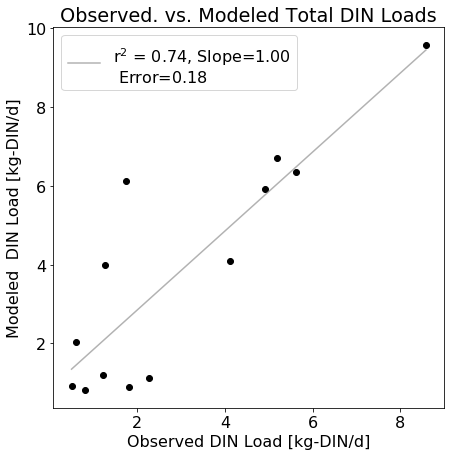

In [10]:
plt.rcParams.update({'font.size': 16})

x, y = LoadModel([ results['x'][0], results['x'][1], results['x'][2] ])

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x, y, label ="", color='k')
ax.set_xlabel("Observed DIN Load [kg-DIN/d]", color='k') 
ax.set_ylabel("Modeled  DIN Load [kg-DIN/d]", color='k')

#    # plop on a regression line
mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
r2 = r_value**2
rX = np.linspace(min(x[mask]), max(x[mask]), 50)
rY = slope*rX + intercept
ax.plot(rX,rY, color='grey', linestyle='-', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%1 +"\n Error="+"$%.2f$"%std_err) )   
ax.legend(loc=2) 
plt.title("Observed. vs. Modeled Total DIN Loads")

plt.savefig(os.path.join(fig_path, "Final_plot1.png"), dpi = 300)

#### 8.3) Scatter plot matrices
to see how each WQ variable responds to each source variable.

plotted in a couple of ways cuz plots are fun

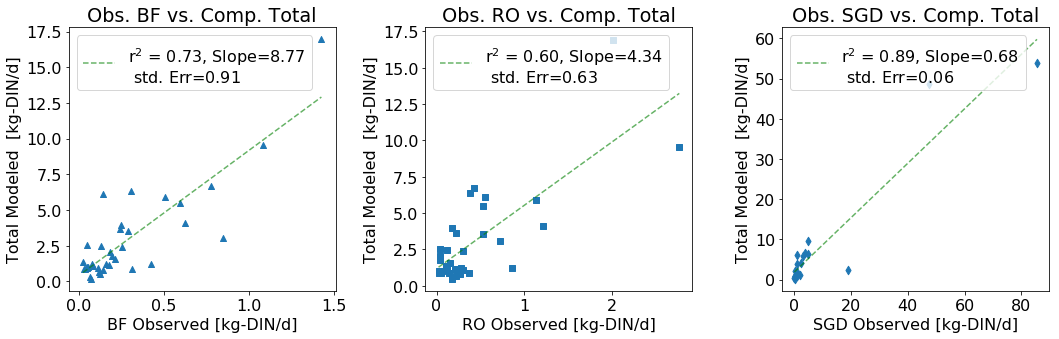

In [79]:
load_list = ['BF_DIN_lOAD_kgNpd', 'RO_DIN_lOAD_kgNpd', 'SGD_DIN_lOAD_kgNpd']
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad', 'Total_ShulerLoad']

plt.rcParams.update({'font.size': 16})

mark = ['^', "s", 'd']

fig, ax = plt.subplots(1,3, figsize=(15, 5))
for idx,  L in enumerate(load_list):

    x = Optomo_frame3[L]
    y = Optomo_frame3['Total_ShulerLoad']
    
    ax[idx].scatter(x, y, label ='', marker=mark[idx])
    ax[idx].set_xlabel(x.name.split("_")[0]+" Observed [kg-DIN/d]", color='k') 
    ax[idx].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')
    
    #    # plop on a regression line
    mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2
    rX = np.linspace(min(x), max(x), 50)
    rY = slope*rX + intercept
    ax[idx].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
    ax[idx].legend(loc=2) 
    ax[idx].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))

    plt.tight_layout()
plt.savefig(os.path.join(fig_path, "flo_type_matrix.png"), dpi = 300)     

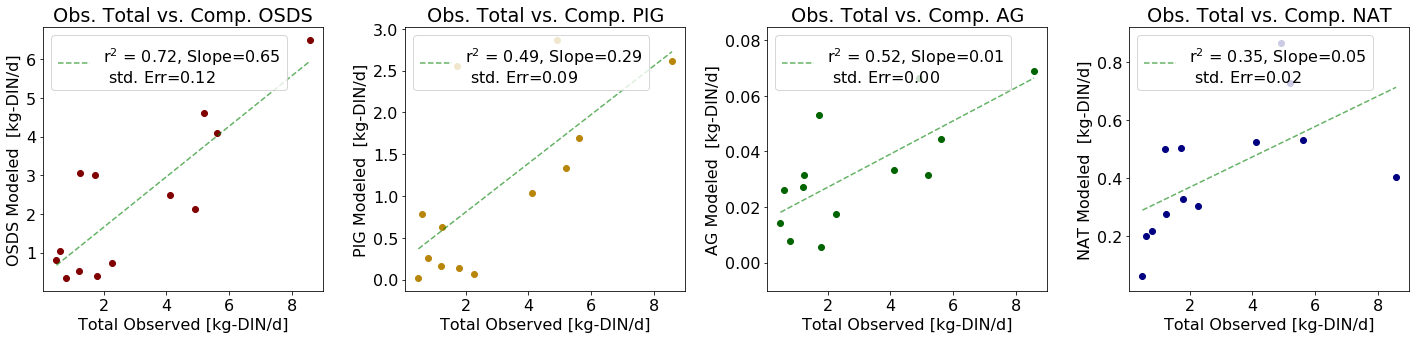

In [80]:
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad']

fig, ax = plt.subplots(1,4, figsize=(20, 5))

colo = np.array(["maroon", "darkgoldenrod", "darkgreen", "navy"])
           
for idx,  L in enumerate(LU_list):

    y = Optomo_frame3[L]
    x = Optomo_frame3['Total_DIN_lOAD_kgNpd']
    
    ax[idx].scatter(x, y, label ='', c = colo[idx])
    ax[idx].set_xlabel(x.name.split("_")[0]+" Observed [kg-DIN/d]", color='k') 
    ax[idx].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')
    
    #    # plop on a regression line
    mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2
    rX = np.linspace(min(x), max(x), 50)
    rY = slope*rX + intercept
    ax[idx].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
    ax[idx].legend(loc=2) 
    ax[idx].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))

    plt.tight_layout()
plt.savefig(os.path.join(fig_path, "Source_type_matrix.png"), dpi = 300)     

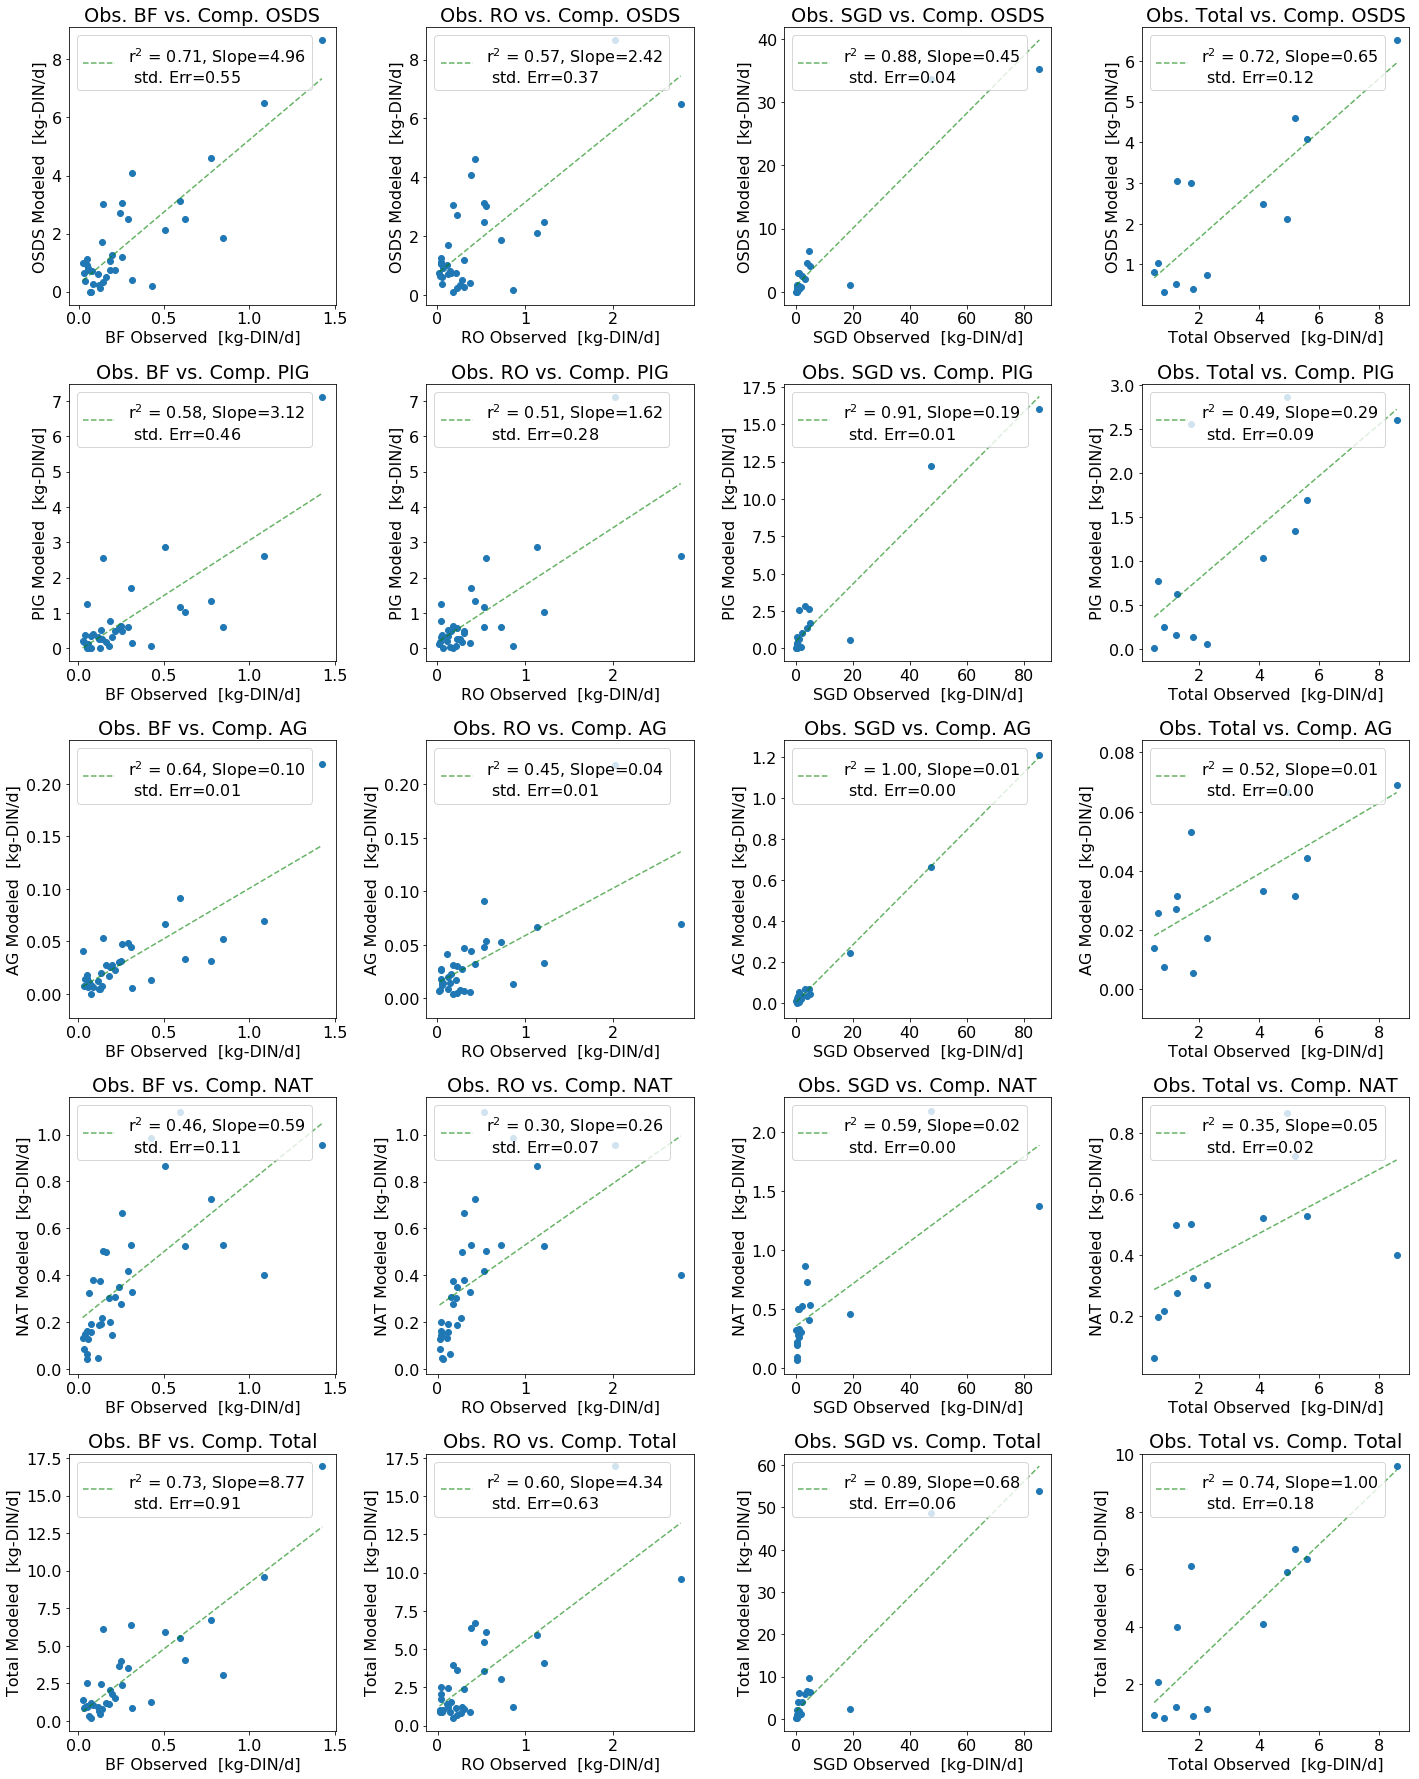

In [76]:
load_list = ['BF_DIN_lOAD_kgNpd', 'RO_DIN_lOAD_kgNpd', 'SGD_DIN_lOAD_kgNpd', 'Total_DIN_lOAD_kgNpd']
LU_list = ['OSDS_ShulerLoad', 'PIG_ShulerLoad', 'AG_ShulerLoad', 'NAT_ShulerLoad', 'Total_ShulerLoad']


plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(5,4, figsize=(20, 25))
nrow  = -1 # plot iterators

for L in load_list:
    ncol = -1   # plot iterators
    nrow = nrow+1  # plot iterators
    x = Optomo_frame3[L]
    
    for U in LU_list:
        ncol = ncol+1  # plot iterators
    
        y = Optomo_frame3[U]

        ax[ncol,nrow].scatter(x, y, label ='')
        ax[ncol,nrow].set_xlabel(x.name.split("_")[0]+" Observed[kg-DIN/d]", color='k') 
        ax[ncol,nrow].set_ylabel(y.name.split("_")[0]+" Modeled  [kg-DIN/d]", color='k')

    #    # plop on a regression line
        mask = ~np.isnan(x) & ~np.isnan(y) # regression does not like NaN values, this line masks them out and regression is only performed on finite numbers
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[mask], y[mask])   # calculate regression stats for the ecoli and rainfall data
        r2 = r_value**2
        rX = np.linspace(min(x), max(x), 50)
        rY = slope*rX + intercept
        ax[ncol,nrow].plot(rX,rY, color='g', linestyle='--', alpha = .6, label = ("r$^2$ = " + "$%.2f$"%r2 +", Slope="+"$%.2f$"%slope +"\n std. Err="+"$%.2f$"%std_err) )   
        ax[ncol,nrow].legend(loc=2) 
        ax[ncol,nrow].set_title('Obs. {} vs. Comp. {}'.format(x.name.split("_")[0], y.name.split("_")[0]))
        
        plt.tight_layout()

plt.savefig(os.path.join(fig_path, "Scat_matrix.png"), dpi = 300)     

#### 8.4) Area or length scaled DIN loads 

In [12]:
# per area nutrient loading 
Optomo_frame3['Load_per_km2_kgDINpdpkm2'] = Optomo_frame3['Total_ShulerLoad'] / (Optomo_frame3['area_m2']/1000000)

# Per lengh of coastline loading make a column for the total shuler load per coastline length for a figure result
Optomo_frame3['DINpKm_len'] = Optomo_frame3['Total_ShulerLoad'] / Optomo_frame3['s_len_km']

#### 8.5) Prioritization ranking using absolute and scaled loads 

In [13]:
Prioritization_frame = Optomo_frame3.copy()     # dont mess with original dataframe

# find averages of each metric 
DINpKm_len_mean = Prioritization_frame['DINpKm_len'].mean()
Total_ShulerLoad_mean = Prioritization_frame['Total_ShulerLoad'].mean()
Load_per_km2_kgDINpdpkm2_mean = Prioritization_frame['Load_per_km2_kgDINpdpkm2'].mean()

# find anomolies for later ranking
Prioritization_frame['DINpKm_len_anomoly'] = Prioritization_frame['DINpKm_len'] - DINpKm_len_mean
Prioritization_frame['Total_ShulerLoad_anomoly'] = Prioritization_frame['Total_ShulerLoad'] - Total_ShulerLoad_mean
Prioritization_frame['Load_per_km2_kgDINpdpkm2_anomoly'] = Prioritization_frame['Load_per_km2_kgDINpdpkm2'] - Load_per_km2_kgDINpdpkm2_mean

# rank the anomoloies, 1 to 93
Prioritization_frame['DINpKm_len_RANK'] = Prioritization_frame['DINpKm_len_anomoly'].rank(ascending=True)
Prioritization_frame['Total_ShulerLoad_RANK'] = Prioritization_frame['Total_ShulerLoad_anomoly'].rank(ascending=True)
Prioritization_frame['Load_per_km2_kgDINpdpkm2_RANK'] = Prioritization_frame['Load_per_km2_kgDINpdpkm2_anomoly'].rank(ascending=True)

# add each of the ranks (this means equal weight is placed on each one) 
Prioritization_frame['Rank_sum'] = Prioritization_frame['DINpKm_len_RANK'] + Prioritization_frame['Total_ShulerLoad_RANK'] + Prioritization_frame['Load_per_km2_kgDINpdpkm2_RANK']

# rank those again to get 1-93 rank, note the 1 is highest impact here
Prioritization_frame['Ranked_RANK'] = Prioritization_frame['Rank_sum'].rank(ascending=False)

# sort it so 1 is on top
Prioritization_frame = Prioritization_frame.sort_values("Ranked_RANK", ascending=False)

### 9) D15N Predicted Isotope model

In [14]:
f_OSDS = Optomo_frame3['OSDS_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_Pig = Optomo_frame3['PIG_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_AG = Optomo_frame3['AG_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']
f_Nat= Optomo_frame3['NAT_ShulerLoad']/Optomo_frame3['Total_ShulerLoad']

D_OSDS = 9
D_Pig = 14
D_AG = 0
D_Nat = 4

Optomo_frame3['predicted_D15N_permil'] = (f_OSDS*D_OSDS + f_Pig*D_Pig + f_AG*D_AG + f_Nat*D_Nat)
overall_ave_d15N = Optomo_frame3['predicted_D15N_permil'].mean()

Optomo_frame3['predicted_D15N_relative']= (Optomo_frame3['predicted_D15N_permil'] - overall_ave_d15N)

### 10) Save Final Data files

In [15]:
# stick on a geometry column to make the shapefile have shapes
bounds = geopandas.read_file(os.path.join("..", "Raw_data", "GIS", "Basin_boundaries.shp"))
# merge on the land use factors with  the water quality sample data (average frame) 
Final_shp = bounds.merge(Optomo_frame3, on='Uniqe_ID', how='left')

Final_shp.to_file(os.path.join(Output, 'Final_loading_model3_fixed.shp'),driver ='ESRI Shapefile') 
Optomo_frame3.to_csv(os.path.join(Output, 'Final_loading_model3_fixed.csv'))


# make a shoreline frame
perims = geopandas.read_file(os.path.join("..", "Raw_data", "GIS",  "Sub_basin_perimeters.shp"))   # open up perimiters file
# merge on the desired cols
Final_shp_perims = perims.merge(Optomo_frame3, on='Uniqe_ID', how='outer')
# send to shapefile
Final_shp_perims.to_file(os.path.join(Output, 'Final_loading_model3_fixed_coastline.shp'),driver ='ESRI Shapefile') 


# Prioritization_frame  shapefle of basin prioritization ranks
RANK_shp = bounds.merge(Prioritization_frame, on='Uniqe_ID', how='left')
RANK_shp.to_file(os.path.join(Output, 'Final_Rank3_fixed.shp'),driver ='ESRI Shapefile') 

### 11) Print specific results in notebook for users direct information

In [16]:
# This prints out the total loading for the whole island from each source  

# look at the total percent of the total loading from each WB component in those sheds with all of the components measured
Optomo_frame3['BF_pct_o_Total_load'] =  Optomo_frame3['BF_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 
Optomo_frame3['RO_pct_o_Total_load'] =  Optomo_frame3['RO_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 
Optomo_frame3['SGD_pct_o_Total_load'] =  Optomo_frame3['SGD_DIN_lOAD_kgNpd'] / Optomo_frame3['Total_DIN_lOAD_kgNpd'] 

# print out here in notebook
print("OSDS load is {} kg/d".format(Optomo_frame3['OSDS_ShulerLoad'].sum()))
print("PIG load is {} kg/d".format(Optomo_frame3['PIG_ShulerLoad'].sum()))
print("Ag load is {} kg/d".format(Optomo_frame3['AG_ShulerLoad'].sum()))
print("NAT load is {} kg/d".format(Optomo_frame3['NAT_ShulerLoad'].sum()))
print("Total load is {} kg/d".format(Optomo_frame3['Total_ShulerLoad'].sum()))

OSDS load is 259.97340616190326 kg/d
PIG load is 111.71093525853075 kg/d
Ag load is 6.262614866965644 kg/d
NAT load is 33.991355995652704 kg/d
Total load is 411.9383122830524 kg/d


In [17]:
# This prints out a comparison of SWB calculated SGD flux and measured SGD rates from Shuler et al. (2019)

# Rn Algae observations
pSGD= 76.9 ; pSGD_ERR= 46.3 
fSGD= 3.00; fSGD_ERR= 1.15
vSGD= 1.13 ; vSGD_ERR= .04 
oSGD= 0.42 ; oSGD_ERR= 0.15 

pBF = 0.33 ; pBF_ERR = 0.18 
fBF = 0.33 ; fBF_ERR = 0.17 
vBF = 0.28 ; vBF_ERR = 0.33 

pDIN_Rn_algae = pSGD + pBF ; pDIN_Rn_algae_ERR = add_err(pSGD_ERR , pBF_ERR )
fDIN_Rn_algae = fSGD + fBF ; fDIN_Rn_algae_ERR = add_err(fSGD_ERR , fBF_ERR )
vDIN_Rn_algae = vSGD + vBF ; vDIN_Rn_algae_ERR = add_err(vSGD_ERR , vBF_ERR )
oDIN_Rn_algae = oSGD       ; oDIN_Rn_algae_ERR = oSGD_ERR

# compare to Rn Algae fluxes
falu = Optomo_frame3[Optomo_frame3['Uniqe_ID'] == 'WS_9_Fagaalu']
falu_a = falu[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
falu_b = falu_a.sum()

pala = Optomo_frame3[Optomo_frame3.Uniqe_ID.isin(['WS_31_Nuuuli Pala','WS_88_Nuuuli Pala'])]
pala_a = pala[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
pala_b = pala_a.sum()

vati = Optomo_frame3[Optomo_frame3.Uniqe_ID.isin(['WS_91_Vatia','WS_92_Vatia', 'WS_90_Vatia'])]
vati_a = vati[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
vati_b = vati_a.sum()

oa = Optomo_frame3[Optomo_frame3['Uniqe_ID'] == 'WS_89_Afono']
oa_a = oa[['Uniqe_ID', 'SGD_m3pd', 'SGD_std', 'Total_ShulerLoad']]
oa_b = oa_a.sum()

compare_SGD_frame = pd.concat([pala_b, falu_b, vati_b, oa_b], axis=1).transpose()
compare_SGD_frame['Rn_algae_h2o'] = ['68,482 (74,126)',      '7,270 (4,455)', '4,428 (2,027)', '2,258 (1,891)'  ]
compare_SGD_frame['Rn_algae_DIN'] = [pDIN_Rn_algae, fDIN_Rn_algae, vDIN_Rn_algae, oDIN_Rn_algae]
compare_SGD_frame['Rn_algae_DIN_ERR'] = [pDIN_Rn_algae_ERR, fDIN_Rn_algae_ERR, vDIN_Rn_algae_ERR, oDIN_Rn_algae_ERR]

compare_SGD_frame

,Uniqe_ID,SGD_m3pd,SGD_std,Total_ShulerLoad,Rn_algae_h2o,Rn_algae_DIN,Rn_algae_DIN_ERR
0,WS_88_Nuuuli Pala,61821.9,44290.3,48.7597,"68,482 (74,126)",77.23,46.300350
1,WS_9_Fagaalu,11925.8,8543.89,6.70528,"7,270 (4,455)",3.33,1.162497
2,WS_90_VatiaWS_91_VatiaWS_92_Vatia,15848.3,11354,6.50992,"4,428 (2,027)",1.41,0.332415
3,WS_89_Afono,1787.76,1280.78,0.192141,"2,258 (1,891)",0.42,0.150000
